# Regression

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

os.chdir('/content/drive/MyDrive/IronInsight')
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1SHD0yiUoI9-SpXYjMN5V3vbZ8Smp8HIv/IronInsight'

In [3]:
import numpy as np
import pandas as pd

In [4]:
df = pd.read_csv('cleaned_data_v3.csv')

In [5]:
df.head()

,Name,Sex,Age,BodyweightKg,WeightClassKg,BestBench,Date
0,Maysar Olaymi,M,24.0,43.5,49.0,91.0,2017-02-21
1,Mohammad Alshnaiti,M,15.0,39.5,49.0,70.0,2017-02-21
2,Ali Al-Darraji,M,35.0,52.3,54.0,142.0,2017-02-21
3,Ziad Androun,M,31.0,63.5,65.0,131.0,2017-02-21
4,Hasan Al-Tameemi,M,39.0,64.4,65.0,157.0,2017-02-21


## Want data in form good for Regression
* OHE for Sex feature

In [6]:
from sklearn.preprocessing import OneHotEncoder


enc = OneHotEncoder(sparse_output=False)
encoded_sex = enc.fit_transform(df[['Sex']])
encoded_columns = enc.get_feature_names_out(['Sex'])
encoded_df = pd.DataFrame(encoded_sex, columns=encoded_columns, index=df.index)


df = pd.concat([df, encoded_df], axis=1)
df.drop('Sex', axis=1, inplace=True)
# df.drop('Date', axis=1, inplace=True)
df

,Name,Age,BodyweightKg,WeightClassKg,BestBench,Date,Sex_F,Sex_M,Sex_Mx
0,Maysar Olaymi,24.0,43.5,49.0,91.0,2017-02-21,0.0,1.0,0.0
1,Mohammad Alshnaiti,15.0,39.5,49.0,70.0,2017-02-21,0.0,1.0,0.0
2,Ali Al-Darraji,35.0,52.3,54.0,142.0,2017-02-21,0.0,1.0,0.0
3,Ziad Androun,31.0,63.5,65.0,131.0,2017-02-21,0.0,1.0,0.0
4,Hasan Al-Tameemi,39.0,64.4,65.0,157.0,2017-02-21,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
726421,Mostafa Ali Alfaky,35.0,146.3,120.0,155.0,2022-10-13,0.0,1.0,0.0
726422,Ibrahim Sandogji,17.0,64.4,66.0,120.0,2022-10-13,0.0,1.0,0.0
726423,Feras Alwahhabi,17.0,82.9,83.0,112.5,2022-10-13,0.0,1.0,0.0
726424,Musab Alessa,17.0,91.3,93.0,130.0,2022-10-13,0.0,1.0,0.0


# We want get the progression for each lifter
* Sort by name and date


In [7]:
df = df.sort_values(by=['Name', 'Date']).reset_index(drop=True)

# Now, we want a metric to see how long each lifter has been competing
* We can add a feature to track how long it has been since a lifter's first meet
  * TimeSinceFirstMeet measured in months
  * Should we keep lifters with 1 meet? Yes for now

In [8]:
# Convert Date feature from string to date form
df['Date'] = pd.to_datetime(df['Date'])

# Create new feature
df['DaysSinceFirstMeet'] = df.groupby('Name')['Date'].transform(lambda x: (x - x.min()).dt.days)

# Drop date field, since we now have a useful time metric
df.drop('Date', axis=1, inplace=True)

# Filter by number of meets

In [9]:
min_meets = 1
df = df.groupby('Name').filter(lambda x: len(x) > min_meets)

# How should we actually use regression?
* We want a good prediction of bench increase after x days
* Alone, age and days since first lift don't seem like a good predictor
* Let's add BenchIncrease and InitialBench features to help capture the increase more specifically. We will predict BenchIncrease (since the first meet), and use the InitialBench feature to help improve accuracy.

In [10]:
# Get bench increase
df['BenchIncrease'] = df.groupby('Name')['BestBench'].transform(lambda x: x - x.iloc[0])

# Get initial bench
df['InitialBench'] = df.groupby('Name')['BestBench'].transform(lambda x: x.iloc[0])
df.head(3)

,Name,Age,BodyweightKg,WeightClassKg,BestBench,Sex_F,Sex_M,Sex_Mx,DaysSinceFirstMeet,BenchIncrease,InitialBench
0,A Kashirin,27.5,72.5,74.0,130.0,0.0,1.0,0.0,0,0.0,130.0
1,A Kashirin,27.5,73.5,74.0,145.0,0.0,1.0,0.0,184,15.0,130.0
2,A'Dren Hye,21.5,92.0,93.0,165.0,0.0,1.0,0.0,0,0.0,165.0


# Looking for outliers in BenchIncrease

In [11]:
sorted = df.copy()
sorted.sort_values(by='BenchIncrease', ascending=True, inplace=True)
sorted.head(3)
original = df.copy()

# More data cleaning
As seen above, some lifters had an increase of up to 182.5 kg in as little as 720 days. Without getting into whether this is actually possible naturally, these points will throw off the predictions of our models as DaysSinceFirstMeet increases. Let's filter out increases past a certain threshold to start and see if it increases accuracy.

There are also ton of negative BenchIncrease instances and DaysSinceFirstMeet of 0. These will both likely throw off the models significantly, so let's drop them.

In [12]:
increase_cutoff = 100
days_cutoff = 4250

df = original.copy()
df = df[df['BenchIncrease'] >= 0.1]
df = df[df['DaysSinceFirstMeet'] > 0]
df = df[df['BenchIncrease'] < increase_cutoff]
df = df[df['DaysSinceFirstMeet'] <= days_cutoff]
df.head(3)

,Name,Age,BodyweightKg,WeightClassKg,BestBench,Sex_F,Sex_M,Sex_Mx,DaysSinceFirstMeet,BenchIncrease,InitialBench
1,A Kashirin,27.5,73.50,74.0,145.00,0.0,1.0,0.0,184,15.00,130.0
3,A'Dren Hye,21.5,99.16,100.0,185.97,0.0,1.0,0.0,266,20.97,165.0
5,A'Dren Hye,23.5,104.10,105.0,195.00,0.0,1.0,0.0,749,30.00,165.0


# Check BenchIncrease distribution

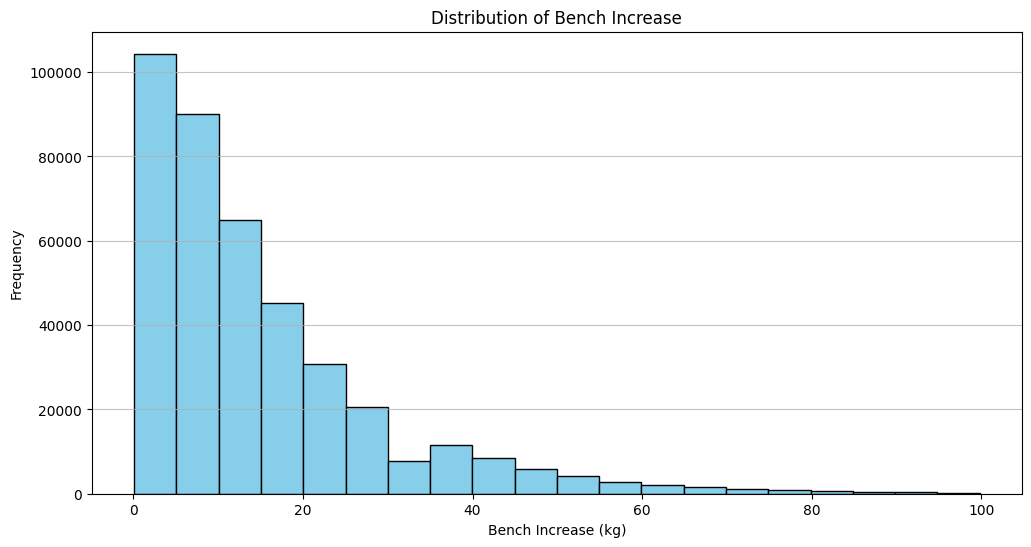

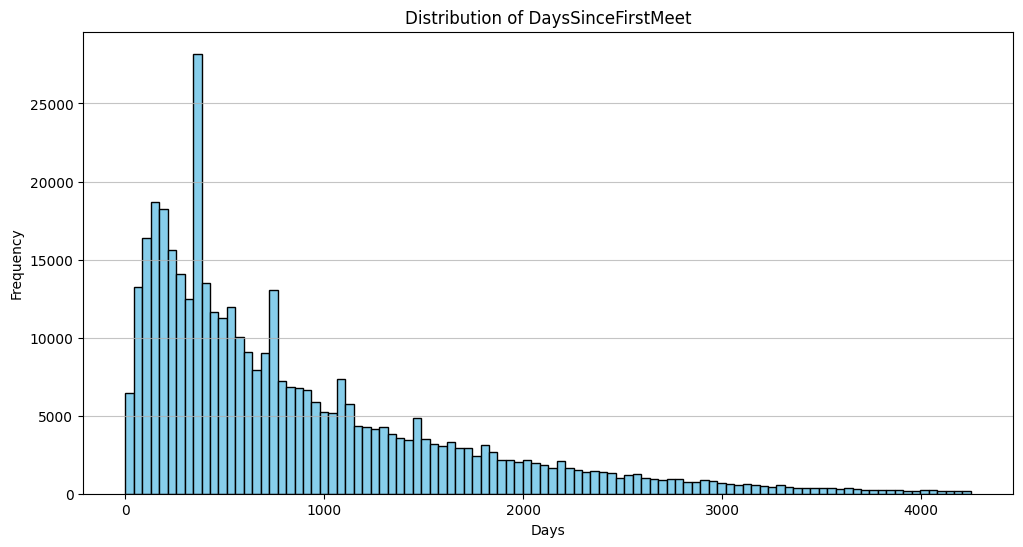

In [13]:
import matplotlib.pyplot as plt

# Plot the distribution of BenchIncrease
plt.figure(figsize=(12, 6))
plt.hist(df['BenchIncrease'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Bench Increase')
plt.xlabel('Bench Increase (kg)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Plot the distribution of BenchIncrease
plt.figure(figsize=(12, 6))
plt.hist(df['DaysSinceFirstMeet'], bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of DaysSinceFirstMeet')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Log features
To capture the logarithmic nature of lifting progress, let's also take the log of InitialBench.

Let's also remove instances where BenchIncrease is 0 or less, and instances where DaysSinceFirstMeet is 0.

In [14]:
df['Log(InitialBench)'] = np.log(df['InitialBench'])
df['Log(BenchIncrease)'] = np.log(df['BenchIncrease'])
df['Log(DaysSinceFirstMeet)'] = np.log(df['DaysSinceFirstMeet'])
df.head(1)

,Name,Age,BodyweightKg,WeightClassKg,BestBench,Sex_F,Sex_M,Sex_Mx,DaysSinceFirstMeet,BenchIncrease,InitialBench,Log(InitialBench),Log(BenchIncrease),Log(DaysSinceFirstMeet)
1,A Kashirin,27.5,73.5,74.0,145.0,0.0,1.0,0.0,184,15.0,130.0,4.867534,2.70805,5.214936


# Separating male/female data
For regression models, sex features could add some unwanted complexity. Let's create versions of the data separated by sex, and we can test both separated and unseparated data sets to see which perform better.

In [ ]:
#df_male = df[df['Sex_M'] == 1.0]
#df_male.drop(['Sex_F', 'Sex_M', 'Sex_Mx'], axis=1, inplace=True)
#df_female = df[df['Sex_F'] == 1.0]
#df_female.drop(['Sex_F', 'Sex_M', 'Sex_Mx'], axis=1, inplace=True)

<ipython-input-20-e56375ab677b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_male.drop(['Sex_F', 'Sex_M', 'Sex_Mx'], axis=1, inplace=True)
<ipython-input-20-e56375ab677b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_female.drop(['Sex_F', 'Sex_M', 'Sex_Mx'], axis=1, inplace=True)


# Now we can try some different regression / time series models
Possible options:
* Linear regression
* Ridge or Elastic Net (we likely don't want to discard features)
* ARIMA (Autoregressive Integrated Moving Average)


First, let's try linear regression.

# Feature selection

In [15]:
from sklearn.model_selection import train_test_split

# Select features
X_features = ['Sex_M', 'Sex_F', 'Sex_Mx', 'Age', 'BodyweightKg','Log(DaysSinceFirstMeet)', 'Log(InitialBench)']
y_feature = 'Log(BenchIncrease)'

#X_male = df_male[X_features]
#y_male = df_male[y_feature]

#X_female = df_female[X_features]
#y_female = df_female[y_feature]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df[X_features], df[y_feature], test_size=0.2, random_state=42)


In [16]:
print(f"Training set size: {X_train.shape[0]}, testing set size: {X_test.shape[0]}")

Training set size: 323328, testing set size: 80833


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def plot_predictions(y_test, y_pred):
  plt.figure(figsize=(10, 6))
  plt.scatter(y_test, y_pred, alpha=0.5)
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
  plt.xlabel('Actual Values (y_test)')
  plt.ylabel('Predicted Values (y_pred)')
  plt.title('Actual vs Predicted Values')
  plt.show()

class LR:

  def __init__(self, scale=True):
    self.scaler = StandardScaler()
    self.scale = scale
    # Create model
    self.model = LinearRegression()

  def fit(self, X, y):
    # Scale features
    if self.scale:
      X_scaled = self.scaler.fit_transform(X)
    else:
      X_scaled = X
    # Train model
    self.model.fit(X_scaled, y)

  def predict(self, X):
      if self.scale:
        X_scaled = self.scaler.transform(X)
      else:
        X_scaled = X
      self.y_pred = self.model.predict(X_scaled)
      return self.y_pred

  def evaluate(self, y_test, y_pred):
    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)


    print(f'Mean Squared Error: {mse}')
    print(f'R^2 Score: {r2}')
    print(f'Mean Absolute Error: {mae}')


    # Display coefficients and intercept
    print('Coefficients:', self.model.coef_)
    print('Intercept:', self.model.intercept_)
    plot_predictions(y_test, y_pred)


Mean Squared Error: 128.95270205392717
R^2 Score: 0.32237253609773364
Mean Absolute Error: 7.595237834137842
Coefficients: [ 8.16288218e+10  8.16258486e+10  1.18497383e+09 -2.60563850e-01
  2.13691711e-01  4.43589211e-01 -2.66212463e-01]
Intercept: 2.4090471612363653


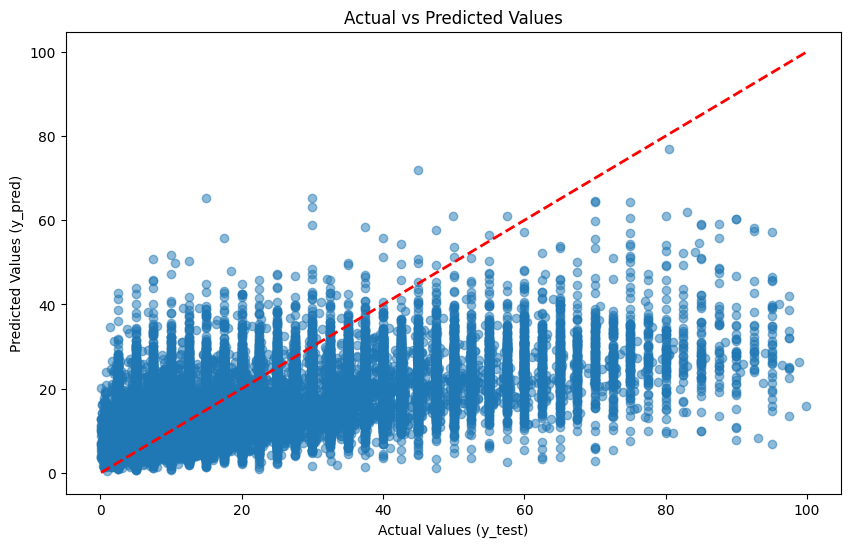

In [18]:
lr = LR(scale=True)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
#lr.evaluate(y_test, y_pred)
lr.evaluate(np.exp(y_test), np.exp(y_pred))

In [ ]:
def predict(age, bodyWeightKG, days, initialBench):
  input = [[age, bodyWeightKG, days, initialBench]]
  y_pred = lr.predict(input)
  print(np.exp(y_pred))
  return y_pred

In [ ]:
predict(21, 100, np.log(365), np.log(110))

[9.4155909]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([2.24236692])

# Elastic net, Ridge and Lasso

In [19]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

class EN(LR):
  def __init__(self, alpha=1.0, l1_ratio=0.5,random_state=42):
    super().__init__()
    self.model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=random_state)

class R(LR):
  def __init__(self, alpha=1.0,random_state=42):
    super().__init__()
    self.model = Ridge(alpha=alpha, random_state=random_state)

class L(LR):
  def __init__(self, alpha=1.0,random_state=42):
    super().__init__()
    self.model = Lasso(alpha=alpha, random_state=random_state)


Elastic
Mean Squared Error: 177.99994825128942
R^2 Score: 0.06463647843676523
Mean Absolute Error: 8.627390888145875
Coefficients: [ 0.02942254 -0.02937015 -0.         -0.08025755  0.04456055  0.20123331
  0.        ]
Intercept: 2.409055871189648


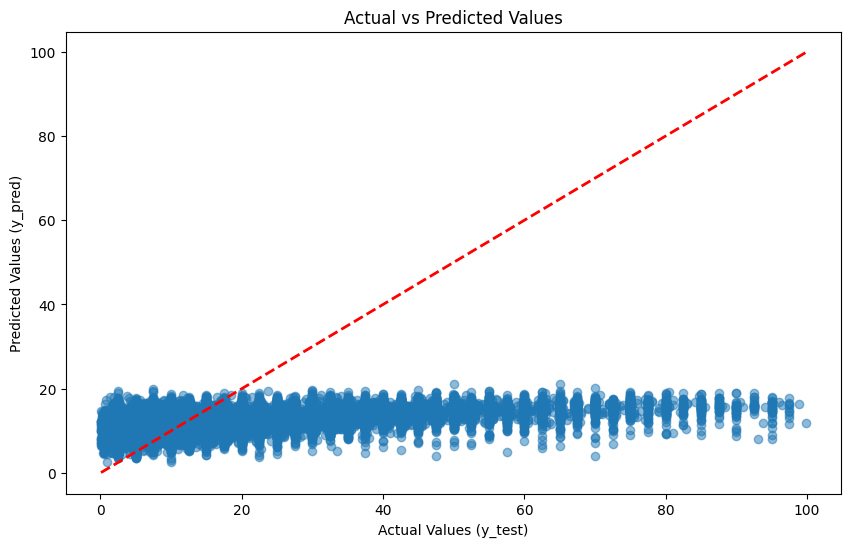

Ridge
Mean Squared Error: 128.95912575667023
R^2 Score: 0.32233878048556497
Mean Absolute Error: 7.5953291357916015
Coefficients: [ 0.130791   -0.13073996 -0.00384353 -0.26054774  0.21367977  0.44357543
 -0.26619665]
Intercept: 2.409055871189648


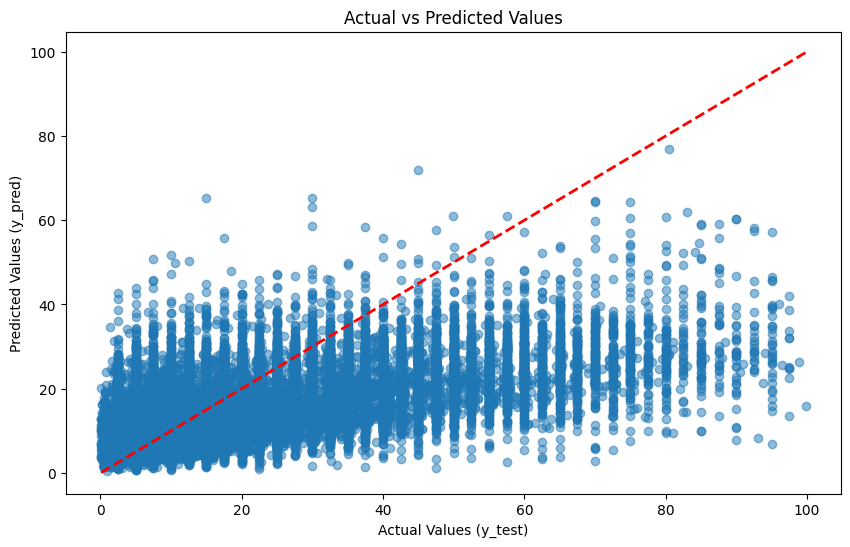

Lasso
Mean Squared Error: 212.5134433362082
R^2 Score: -0.11672685689696394
Mean Absolute Error: 9.627254830555747
Coefficients: [ 0. -0. -0. -0.  0.  0.  0.]
Intercept: 2.409055871189648


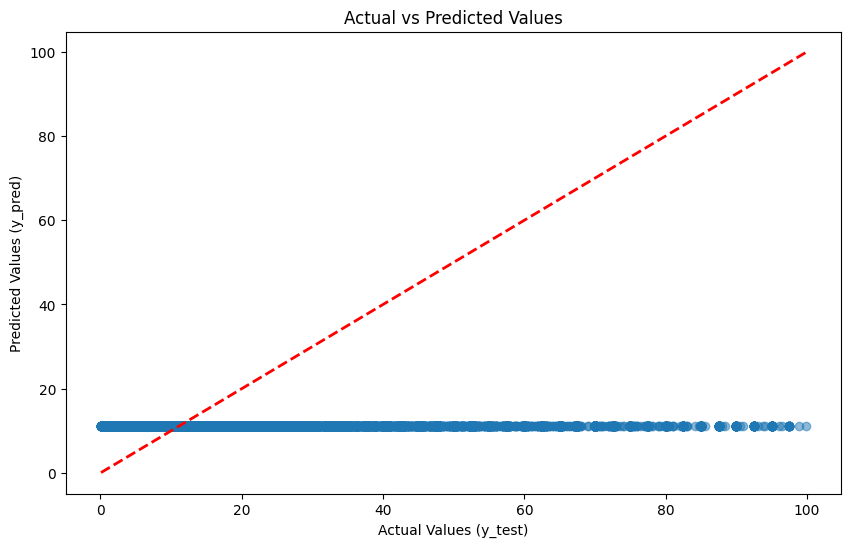

In [20]:
en = EN(alpha=0.7, l1_ratio=0.1)
en.fit(X_train, y_train)
y_pred = en.predict(X_test)
print("Elastic")
en.evaluate(np.exp(y_test), np.exp(y_pred))

ridge = R(alpha=10)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
print("Ridge")
ridge.evaluate(np.exp(y_test), np.exp(y_pred))

lasso = L(alpha=0.7)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
print("Lasso")
lasso.evaluate(np.exp(y_test), np.exp(y_pred))

# Issues
* Both models seem to struggle at both extremes. For smaller values they seem to do decently, but still are a bit off in their results.
* The non-linear progression just might not be well captured with regression, even with log features.

Let's try a time series instead.